# Load libraries and Data

In [1]:
from pyhive import presto

def get_presto_conn():
    # need to impersonate to the owner to drop exisiting tables
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086, username='shahidhya')

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# MP Checkout mweb v3

In [3]:
# latest ramp period
start_date = '2022-05-03'
end_date = '2022-05-18'
test_name = 'mp_checkout_mweb_v3'
control = 'control'
treatment = 'treatment'
# device_cat = "('Personal computer')" 
device_cat = "('Tablet','Smartphone')"
tmp_visitor_base = 'wandajuan.visitor_base_' + test_name
tmp_mp_metrics = 'wandajuan.mp_metrics_' + test_name
tmp_xo_metrics = 'wandajuan.xo_metrics_' + test_name
tmp_xo_funnels = 'wandajuan.xo_funnel_action_' + test_name
tmp_final_table = 'wandajuan.' + test_name

## User Base

In [4]:
# Test user base:

q = """DROP TABLE IF EXISTS {tmp_visitor_base}""".format(tmp_visitor_base=tmp_visitor_base)
pd.read_sql(q, conn)

print('run query below in presto:')


q = """
CREATE TABLE {tmp_visitor_base} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and visitor_id in (
                        select distinct visitor_id
                            from l2.session_analytics core 
                        WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
                          and CAST(country as varchar) in ('US') 
                          and CAST(site_id as varchar) in ('101') 
                          AND device_cat != '' 
                          AND (test_set like '%{test_name}=%') 
                          and device_cat in {device_cat}
                          and session_id not in (
                                            select session_id 
                                            from l2.session_summary 
                                            where user_agent like '%test_automation%' 
                                            and dt>= '{start_date}') 
                      )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_visitor_base=tmp_visitor_base,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,3794


In [5]:
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_visitor_base} group by 1 order by 1""".format(tmp_visitor_base=tmp_visitor_base),conn)

,test_variant,_col1
0,control,1883
1,control_qa,1
2,treatment,1910


with or without dedup, total # visitors in manual pull is more than abdash, which is 1779, 1809, 1

In [6]:
test_users = pd.read_sql('select * from {tmp_visitor_base}'.format(tmp_visitor_base=tmp_visitor_base), conn)
test_users

,visitor_id,test_variant,dt
0,4985b43d-bd44-41f1-bee2-0bd51fe0a5c3,control,2022-05-06
1,70d6988d-712c-4144-9f77-b196a58471ef,control,2022-05-17
2,5b25882f-729a-4ad6-bf3c-0c0a65adc688,treatment,2022-05-04
3,4cf39cc5-7dc8-4120-b3d2-61a4a30011a8,control,2022-05-05
4,5cf82daf-a063-48e9-8c6a-cdd5ccf11f75,treatment,2022-05-05
...,...,...,...
3789,3950d54c-38f3-45ba-be0d-37a402bdb0cf,control,2022-05-16
3790,b8653123-06f2-4e03-be21-87b2eb8c352e,control,2022-05-09
3791,4f061bc3-68b8-4ea7-8654-952c5aa53632,treatment,2022-05-16
3792,cabefd32-9b26-49b2-b210-57c91117dbf1,treatment,2022-05-03


## MP table

In [32]:
# MP Metrics: since there are not that many rows - 2K+ -> pull the entire pos
pd.read_sql('drop table if exists {tmp_mp_metrics}'.format(tmp_mp_metrics=tmp_mp_metrics), conn)


print('run query below in presto:')

q = """
CREATE TABLE {tmp_mp_metrics} AS

select 
		t0.*,
		t2.order_date, 
		t2.order_id,
		t2.created,
		t2.status,
		t2.item_id, 
		t2.house_id,
		t2.item_gmv,
		t2.init_item_commission,
		t2.gmv_net_of_returns,
		t2.net_commission,
		t2.placed_order_item_coupon_amount,
		t2.is_trade_program,
		t2.session_id,
		t2.medium,
		t2.l1_category,
		t2.browser,
		t2.os,
		t2.device_cat,
		t2.channel,
		t2.new_visitor,
		t2.landing_page_class,
		
		( case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
		( case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
		( case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
		( case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
		( case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
		( case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
		( case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
		( case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv
from {tmp_visitor_base} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0
  -- not excluding trade orders 
--  and is_trade_program = 0
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_mp_metrics = tmp_mp_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,3228


In [71]:
# mp = pd.read_sql("select * from {tmp_mp_metrics}".format(tmp_mp_metrics=tmp_mp_metrics), conn)
# mp

## XO Table

In [17]:
# Checkout Metrics:

pd.read_sql('drop table if exists {tmp_xo_metrics}'.format(tmp_xo_metrics=tmp_xo_metrics), conn)


print('run query below in presto:')

q = """
CREATE TABLE {tmp_xo_metrics} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*
from {tmp_visitor_base} t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_xo_metrics = tmp_xo_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,12715


In [9]:
# xo = pd.read_sql("select * from {tmp_xo_metrics}".format(tmp_xo_metrics = tmp_xo_metrics), conn)
# xo

## XO funnel actions

In [33]:

# Checkout funnel with sign in status at the time of performing checkout actions:
pd.read_sql('drop table if exists {tmp_xo_funnels}'.format(tmp_xo_funnels=tmp_xo_funnels), conn)

print('run query below in presto:')

q = """
CREATE TABLE {tmp_xo_funnels} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*,
	coalesce(json_extract_scalar(action_metadata, '$.app'), json_extract_scalar(action_metadata, '$.originatingPageData["app"]'))  app,
	coalesce(json_extract_scalar(action_metadata, '$.isUserSignedIn'), json_extract_scalar(action_metadata, '$.originatingPageData["isUserSignedIn"]'))  isUserSignedIn	
from {tmp_visitor_base} t0
join l2.user_action_daily t2
on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
and (t2.action like '%CHECKOUT%' 
--or t2.action like '%CART%'
--or t2.action like '%SIGN%'
)
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_xo_funnels = tmp_xo_funnels,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,21060


In [11]:
# xo_action = pd.read_sql("select * from {tmp_xo_funnels}".format(tmp_xo_funnels=tmp_xo_funnels), conn)
# xo_action

## Final Table

In [34]:
# Final Table:
pd.read_sql('drop table if exists {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)

print('run query below in presto:')

q = """
CREATE TABLE {tmp_final_table} AS

with xo as (

select dt, test_variant, visitor_id, 

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3

)
, mp as (

select order_date, test_variant, visitor_id,

	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3
)
select 
		coalesce(order_date, dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
on xo.visitor_id = mp.visitor_id and xo.dt = mp.order_date
""".format(tmp_xo_metrics=tmp_xo_metrics,
           tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics,
            tmp_visitor_base=tmp_visitor_base,
            start_date=start_date,
            end_date=end_date)


# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,7063


In [36]:
df = pd.read_sql('select * from {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)
df

,dt,test_variant,visitor_id,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-16,control,84999d69-4ef9-4d97-ad16-d00508723425,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-07,treatment,ca1b8af7-c2f2-4a4e-9098-b5e7f4ff2c40,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-13,treatment,61dbe684-d0e6-4dab-aac7-108c958d050c,1,0,1,0,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-18,control,01cf2fa5-d732-4ee8-bf3d-c49515eaebbf,5,4,1,0,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-13,treatment,6e07773e-9698-4efc-8308-d4ab8b96bdb6,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7058,2022-05-15,treatment,327a8426-67f8-4ea0-a47f-888ab2714f7d,1,3,1,0,2,1,3,1,1,0,1.0,1.0,989.95,989.95,178.19,178.19,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,989.95
7059,2022-05-09,treatment,3783a31e-4219-4528-8038-a7d27f7689c4,1,0,1,0,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7060,2022-05-17,treatment,b44a6848-7589-4b14-8c3a-689d300ca75d,0,2,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7061,2022-05-10,control,c808a746-4df3-4c91-8d62-588969f3d5f5,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Helper functions

In [15]:
def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df
def color_negative_red(row):
    """ Color code lift or drop in test result dataframe if it is significant """
    return ['color: green' if row['Lift'] > 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else 'color: red' if row['Lift'] < 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else '' for v in row]

In [16]:
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment Size', 'Treatment Total', 'Treatment Mean',
               'Control Size', 'Control Total', 'Control Mean', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)]['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)]['visitors'].sum()
    total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric]
        trt = input_df[(input_df['test_variant'] == treatment)][metric]
        
        ctl_total = (input_df[(input_df['test_variant'] == control)][metric]*input_df[(input_df['test_variant'] == control)]['visitors']).sum()
        trt_total = (input_df[(input_df['test_variant'] == treatment)][metric]*input_df[(input_df['test_variant'] == treatment)]['visitors']).sum()
        
        row = [metric, trt_size, trt_total, trt.mean(), ctl_size, ctl_total, ctl.mean(), stats.ttest_ind(ctl, trt).pvalue]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 
                           'Control Total', 'Control Mean', 'Lift', 'Lift_%','P-value']]

# Analysis

## User distribution

In [37]:
df.groupby('test_variant')['visitor_id'].nunique()

test_variant
control       1883
control_qa       1
treatment     1910
Name: visitor_id, dtype: int64

In [38]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique')

test_variant,control,control_qa,treatment
dt,,,
2022-05-03,130.0,NaN,129.0
2022-05-04,152.0,NaN,143.0
2022-05-05,183.0,1.0,157.0
2022-05-06,173.0,NaN,146.0
2022-05-07,203.0,NaN,189.0
...,...,...,...
2022-05-14,248.0,NaN,240.0
2022-05-15,270.0,NaN,262.0
2022-05-16,282.0,NaN,285.0


<AxesSubplot:xlabel='dt'>

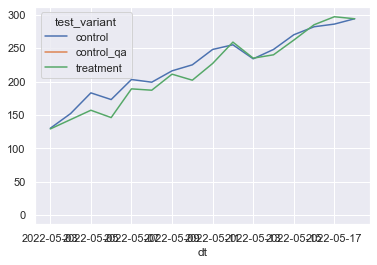

In [39]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique').plot()

## Remove outliers

In [40]:
# exclude qa
df = df.loc[~df['test_variant'].str.contains('qa')]

In [41]:
df[['dt', 'test_variant', 'visitor_id', 'order_gmv']].sort_values(by='order_gmv', ascending=False)

,dt,test_variant,visitor_id,order_gmv
3488,2022-05-13,control,3facd327-75d6-4084-82b4-a0c484e6138c,10627.00
3596,2022-05-06,treatment,d3d9656d-3d71-4b8b-92ef-9b36ebd1c413,6700.00
5130,2022-05-10,control,34665577-28f8-4c24-9dd9-dcbe0a8ad20b,6243.00
390,2022-05-18,treatment,ffec8512-5630-44ac-9ea3-1c15d2ca9fb2,5040.99
6712,2022-05-03,control,47d3ad3b-f44b-461b-9473-30c3284ce565,4790.01
...,...,...,...,...
7056,2022-05-10,treatment,46e137a4-18a0-4d4f-a4f8-f6459b73e661,NaN
7057,2022-05-18,treatment,eebb2381-275f-4918-bd50-d22535b6cd59,NaN
7059,2022-05-09,treatment,3783a31e-4219-4528-8038-a7d27f7689c4,NaN
7060,2022-05-17,treatment,b44a6848-7589-4b14-8c3a-689d300ca75d,NaN


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='order_gmv', ylabel='Density'>

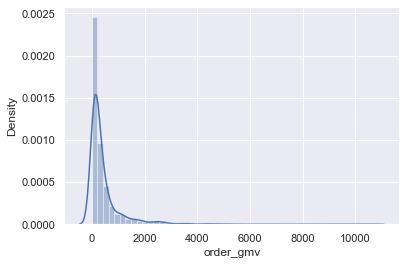

In [42]:
sns.distplot(df['order_gmv'])

<Figure size 1152x288 with 0 Axes>

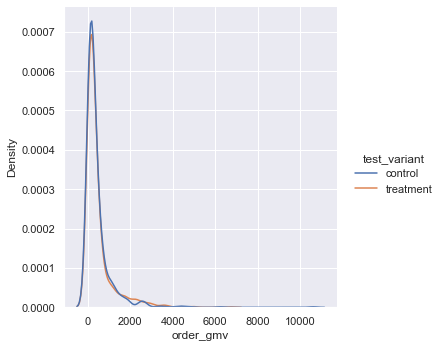

In [43]:
plt.figure(figsize=(16,4)) 
sns.displot(data=df, x='order_gmv', hue='test_variant', kind='kde')

In [44]:
# for some reason, treatment seems to have more large gmv orders
df.loc[df['order_gmv']>3000]['test_variant'].value_counts()

treatment    12
control       9
Name: test_variant, dtype: int64

In [45]:
# excluding 1 large order from control
df = df.loc[df['order_gmv']<10000]

In [46]:
metrics = df.columns[3:]
# df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique())
dtd_metrics = df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique()).reset_index()
dtd_metrics

,dt,test_variant,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-03,control,4.333333,4.757576,1.287879,1.696970,1.303030,1.196970,1.075758,1.378788,1.075758,0.893939,1.121212,1.500000,392.175303,390.811667,96.325827,94.962191,0.833333,0.287879,0.757576,0.000000,0.060606,0.303030,241.783333,0.000000,17.151818,133.240152
1,2022-05-03,treatment,5.060000,5.400000,1.360000,1.700000,1.740000,1.180000,1.940000,1.120000,1.200000,0.620000,1.040000,1.960000,551.657200,551.657200,117.547932,117.547932,0.720000,0.320000,0.780000,0.020000,0.040000,0.200000,496.392000,5.385400,7.879800,42.000000
2,2022-05-04,control,4.383333,3.666667,1.016667,1.383333,1.566667,1.600000,1.250000,1.483333,1.050000,0.800000,1.050000,1.316667,426.764667,423.598000,93.473530,90.306863,0.766667,0.283333,0.650000,0.016667,0.050000,0.333333,322.306667,1.883333,8.141500,94.433167
3,2022-05-04,treatment,3.915254,4.711864,1.169492,1.169492,1.542373,1.271186,2.000000,1.067797,1.135593,0.677966,1.135593,1.932203,437.010169,432.280169,85.081180,80.351180,0.728814,0.406780,0.762712,0.016949,0.050847,0.305085,317.547966,6.100847,9.649153,103.712203
4,2022-05-05,control,6.545455,5.272727,1.181818,1.509091,1.454545,1.654545,1.272727,1.309091,1.036364,0.563636,1.127273,1.527273,322.313273,319.222364,73.815336,70.724427,0.781818,0.345455,0.818182,0.018182,0.000000,0.290909,252.063818,0.890909,0.000000,69.358545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,2022-05-16,treatment,4.492063,5.253968,1.222222,1.428571,1.841270,1.555556,2.126984,1.238095,1.253968,0.634921,1.063492,1.714286,351.296032,342.350317,80.989562,72.043848,0.698413,0.365079,0.809524,0.000000,0.015873,0.238095,270.467302,0.000000,7.032222,73.796508
28,2022-05-17,control,3.884615,5.711538,1.096154,1.403846,1.500000,1.461538,1.211538,1.538462,1.115385,0.576923,1.173077,1.826923,458.182115,456.162885,103.131306,101.112075,0.634615,0.538462,0.923077,0.000000,0.000000,0.250000,336.840000,0.000000,0.000000,121.342115
29,2022-05-17,treatment,2.222222,3.809524,1.253968,1.555556,1.825397,1.396825,2.333333,1.285714,1.222222,0.809524,1.047619,1.761905,522.091746,485.487302,133.048595,96.444151,0.714286,0.333333,0.777778,0.000000,0.000000,0.269841,432.251111,0.000000,0.000000,89.840635
30,2022-05-18,control,2.912281,4.035088,1.052632,1.017544,1.263158,1.473684,1.175439,1.561404,1.000000,0.631579,1.000000,1.438596,481.738947,479.984561,115.442719,113.688333,0.631579,0.368421,0.666667,0.000000,0.000000,0.333333,403.237895,0.000000,0.000000,78.501053


## Day to Day Metrics Plot

In [57]:
len(metrics)

26

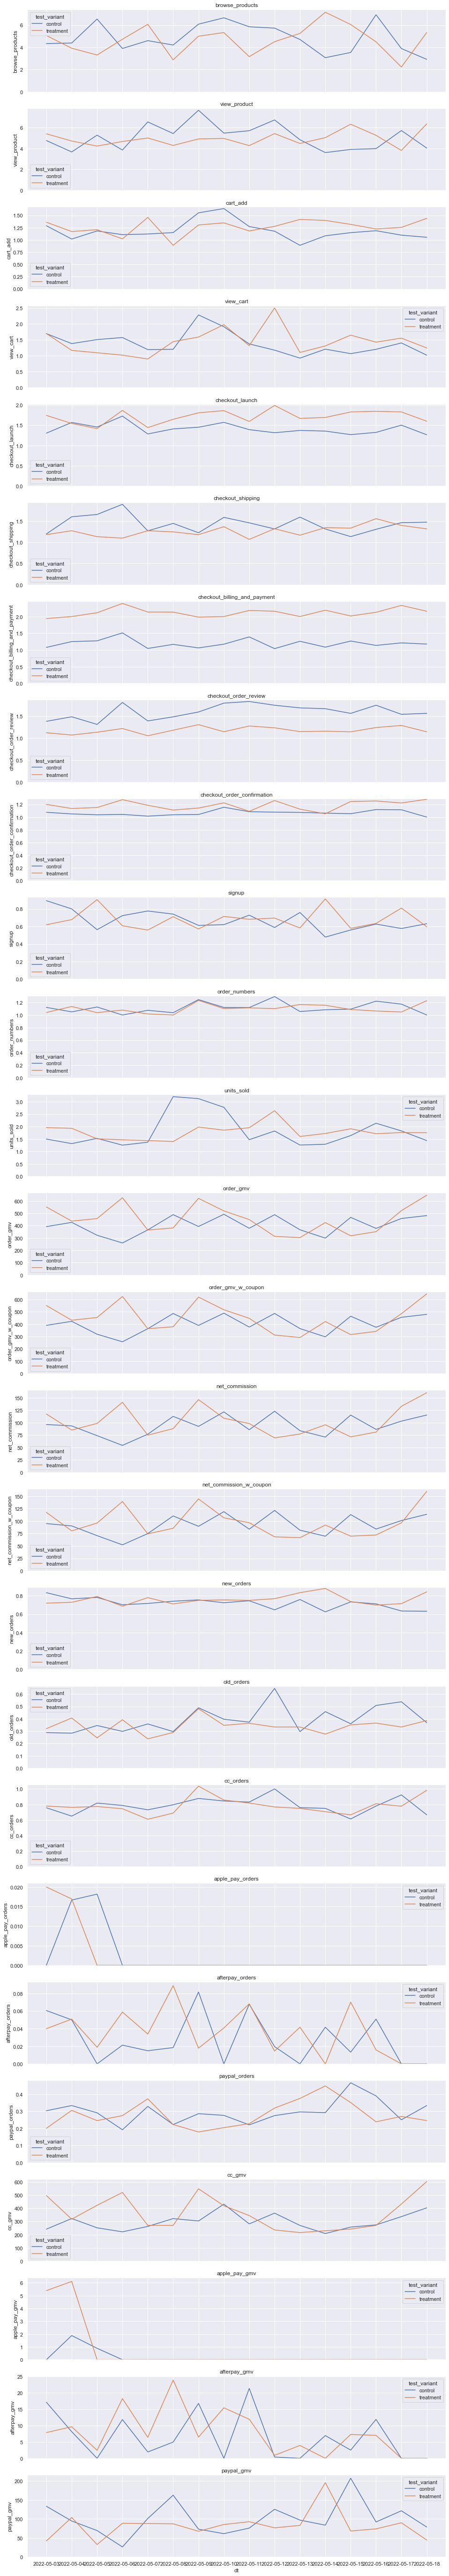

In [47]:
fig, axes = plt.subplots(26, 1, sharex=True, figsize=(16, 100))

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=dtd_metrics, x='dt', y=metric, hue='test_variant')
    axes[i].set_title(metric)
    axes[i].set_ylim(ymin=0)

## Metrics Summary

In [48]:
q = """
select 
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}
where order_gmv < 10000 or order_gmv is null
group by 1, 2
""".format(tmp_final_table=tmp_final_table)

df_all = pd.read_sql(q, conn)

df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,control,19,23,48,60,23,10,27,36,16,14,9,10,8.0,10.0,3072.98,2992.98,762.410,682.410,7.0,1.0,7.0,0.0,0.0,1.0,2396.98,0.0,0.00,676.00
1,treatment,94,18,101,89,17,30,41,27,16,13,8,8,6.0,6.0,1441.60,1044.64,229.790,-167.170,5.0,1.0,5.0,0.0,0.0,1.0,1392.60,0.0,0.00,49.00
2,control,75,17,58,41,16,19,22,26,20,15,17,10,10.0,11.0,3179.72,3179.72,656.498,656.498,8.0,2.0,7.0,0.0,0.0,3.0,1329.23,0.0,0.00,1850.49
3,treatment,12,16,86,77,18,10,24,20,18,7,8,10,7.0,15.0,1758.76,1733.76,426.350,401.350,5.0,2.0,7.0,0.0,0.0,0.0,1758.76,0.0,0.00,0.00
4,treatment,31,26,144,203,30,64,36,30,44,19,21,18,17.0,24.0,6822.16,6797.16,1525.240,1500.240,15.0,2.0,12.0,0.0,4.0,1.0,5693.14,0.0,985.08,143.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,treatment,56,20,57,169,34,19,29,26,19,10,7,12,7.0,9.0,2764.29,2764.29,558.390,558.390,5.0,2.0,3.0,0.0,2.0,2.0,1831.31,0.0,179.98,753.00
197,control,86,21,151,143,34,43,31,32,17,24,10,6,9.0,15.0,1550.81,1550.81,356.224,356.224,3.0,6.0,4.0,0.0,0.0,5.0,675.94,0.0,0.00,874.87
198,treatment,95,24,167,194,25,61,53,32,25,16,13,10,10.0,10.0,6907.83,6827.83,1245.100,1165.100,4.0,6.0,6.0,0.0,0.0,4.0,5892.83,0.0,0.00,1015.00
199,treatment,5,21,98,143,27,32,34,29,24,14,11,8,9.0,13.0,2057.94,2057.94,401.440,401.440,7.0,2.0,5.0,0.0,2.0,2.0,1260.95,0.0,75.25,721.74


In [49]:
# 16 rows with at least 1 na -> fillna with 0
df_all[metrics].isna().sum().sum()
df_all[metrics] = df_all[metrics].fillna(0)

In [50]:
avg_col_list = ['avg_' + m for m in metrics]
df_all[avg_col_list] = df_all[metrics].div(df_all['visitors'], axis=0)
df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,avg_browse_products,avg_view_product,avg_cart_add,avg_view_cart,avg_checkout_launch,avg_checkout_shipping,avg_checkout_billing_and_payment,avg_checkout_order_review,avg_checkout_order_confirmation,avg_signup,avg_order_numbers,avg_units_sold,avg_order_gmv,avg_order_gmv_w_coupon,avg_net_commission,avg_net_commission_w_coupon,avg_new_orders,avg_old_orders,avg_cc_orders,avg_apple_pay_orders,avg_afterpay_orders,avg_paypal_orders,avg_cc_gmv,avg_apple_pay_gmv,avg_afterpay_gmv,avg_paypal_gmv
0,control,19,23,48,60,23,10,27,36,16,14,9,10,8.0,10.0,3072.98,2992.98,762.410,682.410,7.0,1.0,7.0,0.0,0.0,1.0,2396.98,0.0,0.00,676.00,2.086957,2.608696,1.000000,0.434783,1.173913,1.565217,0.695652,0.608696,0.391304,0.434783,0.347826,0.434783,133.607826,130.129565,33.148261,29.670000,0.304348,0.043478,0.304348,0.0,0.000000,0.043478,104.216522,0.0,0.000000,29.391304
1,treatment,94,18,101,89,17,30,41,27,16,13,8,8,6.0,6.0,1441.60,1044.64,229.790,-167.170,5.0,1.0,5.0,0.0,0.0,1.0,1392.60,0.0,0.00,49.00,5.611111,4.944444,0.944444,1.666667,2.277778,1.500000,0.888889,0.722222,0.444444,0.444444,0.333333,0.333333,80.088889,58.035556,12.766111,-9.287222,0.277778,0.055556,0.277778,0.0,0.000000,0.055556,77.366667,0.0,0.000000,2.722222
2,control,75,17,58,41,16,19,22,26,20,15,17,10,10.0,11.0,3179.72,3179.72,656.498,656.498,8.0,2.0,7.0,0.0,0.0,3.0,1329.23,0.0,0.00,1850.49,3.411765,2.411765,0.941176,1.117647,1.294118,1.529412,1.176471,0.882353,1.000000,0.588235,0.588235,0.647059,187.042353,187.042353,38.617529,38.617529,0.470588,0.117647,0.411765,0.0,0.000000,0.176471,78.190000,0.0,0.000000,108.852353
3,treatment,12,16,86,77,18,10,24,20,18,7,8,10,7.0,15.0,1758.76,1733.76,426.350,401.350,5.0,2.0,7.0,0.0,0.0,0.0,1758.76,0.0,0.00,0.00,5.375000,4.812500,1.125000,0.625000,1.500000,1.250000,1.125000,0.437500,0.500000,0.625000,0.437500,0.937500,109.922500,108.360000,26.646875,25.084375,0.312500,0.125000,0.437500,0.0,0.000000,0.000000,109.922500,0.0,0.000000,0.000000
4,treatment,31,26,144,203,30,64,36,30,44,19,21,18,17.0,24.0,6822.16,6797.16,1525.240,1500.240,15.0,2.0,12.0,0.0,4.0,1.0,5693.14,0.0,985.08,143.94,5.538462,7.807692,1.153846,2.461538,1.384615,1.153846,1.692308,0.730769,0.807692,0.692308,0.653846,0.923077,262.390769,261.429231,58.663077,57.701538,0.576923,0.076923,0.461538,0.0,0.153846,0.038462,218.966923,0.0,37.887692,5.536154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,treatment,56,20,57,169,34,19,29,26,19,10,7,12,7.0,9.0,2764.29,2764.29,558.390,558.390,5.0,2.0,3.0,0.0,2.0,2.0,1831.31,0.0,179.98,753.00,2.850000,8.450000,1.700000,0.950000,1.450000,1.300000,0.950000,0.500000,0.350000,0.600000,0.350000,0.450000,138.214500,138.214500,27.919500,27.919500,0.250000,0.100000,0.150000,0.0,0.100000,0.100000,91.565500,0.0,8.999000,37.650000
197,control,86,21,151,143,34,43,31,32,17,24,10,6,9.0,15.0,1550.81,1550.81,356.224,356.224,3.0,6.0,4.0,0.0,0.0,5.0,675.94,0.0,0.00,874.87,7.190476,6.809524,1.619048,2.047619,1.476190,1.523810,0.809524,1.142857,0.476190,0.285714,0.428571,0.714286,73.848095,73.848095,16.963048,16.963048,0.142857,0.285714,0.190476,0.0,0.000000,0.238095,32.187619,0.0,0.000000,41.660476
198,treatment,95,24,167,194,25,61,53,32,25,16,13,10,10.0,10.0,6907.83,6827.83,1245.100,1165.100,4.0,6.0,6.0,0.0,0.0,4.0,5892.83,0.0,0.00,1015.00,6.958333,8.083333,1.041667,2.541667,2.208333,1.333333,1.041667,0.666667,0.541667,0.416667,0.416667,0.416667,287.826250,284.492917,51.879167,48.

In [51]:
df_all.isna().sum().sum()

0

In [52]:
calculate(df_all, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_browse_products,1910,11192.000000,5.8507,1883,11425.000000,6.0475,-0.19673,-3.25%,0.6482
1,avg_view_product,1910,12142.000000,6.4792,1883,12138.000000,6.4497,0.02949,0.46%,0.9470
2,avg_cart_add,1910,2543.000000,1.3264,1883,2491.000000,1.3196,0.00683,0.52%,0.8881
3,avg_view_cart,1910,2932.000000,1.5409,1883,2885.000000,1.5215,0.01934,1.27%,0.8637
4,avg_checkout_launch,1910,3240.000000,1.7045,1883,2597.000000,1.3804,0.32413,23.48%,0.0000
5,avg_checkout_shipping,1910,2397.000000,1.2526,1883,2884.000000,1.5360,-0.28345,-18.45%,0.0000
6,avg_checkout_billing_and_payment,1910,2618.000000,1.3657,1883,1651.000000,0.8766,0.48904,55.79%,0.0000
7,avg_checkout_order_review,1910,1334.000000,0.7034,1883,1813.000000,0.9605,-0.25709,-26.77%,0.0000
8,avg_checkout_order_confirmation,1910,1172.000000,0.6113,1883,1021.000000,0.5402,0.07106,13.15%,0.0140
9,avg_signup,1910,853.000000,0.4441,1883,886.000000,0.4753,-0.03124,-6.57%,0.2024


# Prepare data to session level to slice by sign in status

In [57]:
pd.read_sql('drop table if exists {tmp_final_table}_by_signinstatus'.format(tmp_final_table=tmp_final_table), conn)

q = """
create table {tmp_final_table}_by_signinstatus AS
with xo as (

select dt, test_variant, visitor_id, signin_status, session_id,

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3, 4, 5

)
, mp as (

select 

		order_date, test_variant, visitor_id,
		session_id,
	
	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3, 4
)
, xo_sign as (

		select dt, visitor_id, session_id, cast(bool_or(cast(isusersignedin as boolean)) as int) + cast(bool_and(cast(isusersignedin as boolean)) as int) as signinstatus_xo
		from {tmp_xo_funnels}
		group by 1, 2, 3

)

select 
		coalesce(order_date, xo.dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		coalesce(mp.session_id, xo.session_id) session_id,
		signin_status,
		signinstatus_xo,
		
		
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
on xo.session_id = mp.session_id
left join xo_sign
on coalesce(mp.session_id, xo.session_id) = xo_sign.session_id

""".format(tmp_xo_metrics=tmp_xo_metrics,
		    tmp_xo_funnels=tmp_xo_funnels,
            tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics
			)

# print(q)
pd.read_sql(q, conn)

,rows
0,12724


In [60]:
df_sign = pd.read_sql('select * from {tmp_final_table}_by_signinstatus'.format(tmp_final_table=tmp_final_table), conn)
df_sign

,dt,test_variant,visitor_id,session_id,signin_status,signinstatus_xo,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-15,control,bd2d3535-bbd5-4c88-a1eb-714d30ef5ccb,57fcac38f35861e082525b348fa30310,PARTIAL_SIGNED_IN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,158.0,158.0,44.53,44.53,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,158.0
1,2022-05-11,control,004ee383-5964-439b-89f1-68b857c34957,7279003e212065c6a15dc127cd00b3ba,ALWAYS_SIGNED_IN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-09,control,e3a4a0cd-7088-4f87-a34c-9d22d83f7842,c654fa1976f222e8d2ef00db88afbae3,ALWAYS_SIGNED_IN,NaN,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-13,control,70a3a964-ea1b-4f33-92c9-43bd7bac250c,5f69b3c0620b868714c54b59529419b9,SIGNED_IN_MULTIPLE,0.0,24.0,24.0,2.0,5.0,1.0,7.0,4.0,1.0,1.0,2.0,2.0,2.0,208.0,208.0,54.37,54.37,2.0,0.0,2.0,0.0,0.0,0.0,208.0,0.0,0.0,0.0
4,2022-05-15,treatment,ff403453-3030-43e0-9dc5-3ca9dfaca376,343e5ab244e2cab2ff0a88a0cf4af636,ALWAYS_SIGNED_IN,NaN,40.0,8.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12719,2022-05-06,control,805869f1-3e3b-4e16-ae58-4505f52f4c5c,f0fe680f5d27457c60387a03327d45fc,ALWAYS_SIGNED_IN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12720,2022-05-13,treatment,aa1eac6c-1e6e-4c37-9954-7e7bcc653149,ec9c6d55561f0cf4ac18a96090619ff2,ALWAYS_SIGNED_IN,2.0,7.0,2.0,1.0,5.0,3.0,3.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12721,2022-05-09,treatment,159aba7f-41d9-45af-9f87-982ab6d91429,12b9333a13ce89e416696f6b324e66f6,ALWAYS_SIGNED_IN,2.0,1.0,0.0,0.0,3.0,3.0,2.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12722,2022-05-16,treatment,899e1727-6f51-4a69-a34f-576b27987757,9a07c897f3a80315ccc325feecf63bb9,ALWAYS_SIGNED_IN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
# two fields not completely corelated
df_sign[['signin_status', 'signinstatus_xo']].drop_duplicates()

,signin_status,signinstatus_xo
0,PARTIAL_SIGNED_IN,0.0
1,ALWAYS_SIGNED_IN,NaN
3,SIGNED_IN_MULTIPLE,0.0
6,SIGNED_OUT,0.0
14,SIGNED_OUT,NaN
...,...,...
80,PARTIAL_SIGNED_IN,1.0
352,SIGNED_IN_MULTIPLE,2.0
715,SIGNED_IN_MULTIPLE,1.0
9572,None,NaN


## Slice by session level signin status

In [62]:
# prepare data by slicing `signin_status`
q = """
select 
        signin_status, 
		--signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
""".format(tmp_final_table=tmp_final_table)

df_sign_ss = pd.read_sql(q, conn)

df_sign_ss

,signin_status,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,ALWAYS_SIGNED_IN,control,93,8,75.0,87.0,6.0,9.0,7.0,4.0,4.0,11.0,8.0,0.0,5.0,63.0,1834.04,1794.04,343.93,303.93,1.0,4.0,5.0,0.0,0.0,0.0,1834.04,0.0,0.0,0.00
1,SIGNED_OUT,control,51,20,115.0,111.0,13.0,11.0,12.0,17.0,6.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SIGNED_OUT,treatment,41,15,65.0,140.0,24.0,46.0,31.0,33.0,21.0,7.0,6.0,6.0,6.0,12.0,3307.22,3267.22,805.85,765.85,3.0,3.0,6.0,0.0,0.0,0.0,3307.22,0.0,0.0,0.00
3,SIGNED_OUT,treatment,99,6,29.0,15.0,6.0,1.0,7.0,7.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SIGNED_IN_MULTIPLE,control,72,3,2.0,6.0,2.0,0.0,3.0,4.0,3.0,4.0,3.0,5.0,3.0,3.0,1871.70,1871.70,344.15,344.15,2.0,1.0,1.0,0.0,0.0,2.0,1735.00,0.0,0.0,136.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,ALWAYS_SIGNED_IN,treatment,92,3,5.0,13.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
718,ALWAYS_SIGNED_IN,treatment,91,7,9.0,23.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,SIGNED_IN_MULTIPLE,treatment,80,3,3.0,7.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,2.0,3.0,5.0,930.95,905.95,190.93,165.93,2.0,1.0,1.0,0.0,0.0,2.0,325.97,0.0,0.0,604.98
720,PARTIAL_SIGNED_IN,treatment,38,5,37.0,7.0,2.0,5.0,3.0,5.0,5.0,5.0,3.0,3.0,2.0,4.0,884.24,884.24,208.46,208.46,2.0,0.0,2.0,0.0,0.0,0.0,884.24,0.0,0.0,0.00


In [63]:
df_sign_ss[metrics].isna().sum()
df_sign_ss[metrics] = df_sign_ss[metrics].fillna(0)

In [64]:
def metricSummary(df):
    df[metrics] = df[metrics].fillna(0)
    df[avg_col_list] = df[metrics].div(df['visitors'], axis=0)
    # metricSum = calculate(df, avg_col_list, control, treatment).reset_index()\
    # .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)
    # return metricSum
    return calculate(df, avg_col_list, control, treatment)#.reset_index()#\
    #.drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)


In [65]:
# df_sign_ss.groupby('signin_status').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', 10)
df_sign_ss.groupby('signin_status').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

## Slice by signin status upon checkout

In [66]:
# prepare data by slicing `signin_status during xo`
q = """
select 
        --signin_status, 
		signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
""".format(tmp_final_table=tmp_final_table)

df_sign_xo = pd.read_sql(q, conn)

df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,1.0,treatment,36,2,40,10,2,3,7,7,4,2,1,0,1.0,1.0,41.99,41.99,9.6300,9.6300,1.0,0.0,1.0,0.0,0.0,0.0,41.99,0.0,0.00,0.00
1,2.0,control,43,2,41,24,3,7,5,0,0,7,3,0,3.0,7.0,4972.99,4972.99,1862.3600,1862.3600,0.0,3.0,2.0,0.0,0.0,1.0,619.00,0.0,0.00,4353.99
2,1.0,treatment,18,2,3,3,2,1,5,3,4,5,2,2,1.0,2.0,212.00,212.00,41.4000,41.4000,1.0,0.0,1.0,0.0,0.0,0.0,212.00,0.0,0.00,0.00
3,1.0,treatment,7,1,7,0,1,4,4,2,3,1,2,2,1.0,1.0,26.34,26.34,4.7400,4.7400,1.0,0.0,1.0,0.0,0.0,0.0,26.34,0.0,0.00,0.00
4,1.0,control,93,3,5,7,3,1,6,5,2,2,1,1,1.0,1.0,165.81,165.81,29.8500,29.8500,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,165.81,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,NaN,control,2,10,23,11,0,2,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729,0.0,control,2,13,25,44,14,7,15,20,12,10,4,4,3.0,4.0,2636.95,2636.95,673.2804,673.2804,0.0,3.0,1.0,0.0,0.0,2.0,130.00,0.0,0.00,2506.95
730,0.0,control,31,17,55,124,17,15,21,26,14,10,8,9,7.0,16.0,2598.21,2573.21,642.3300,617.3300,6.0,1.0,5.0,0.0,1.0,1.0,1740.31,0.0,343.90,514.00
731,2.0,treatment,53,5,23,38,9,10,10,2,4,4,3,0,3.0,4.0,985.00,985.00,388.1250,388.1250,1.0,2.0,2.0,0.0,0.0,1.0,827.00,0.0,0.00,158.00


In [72]:
df_sign_xo['signinstatus_xo'].value_counts()

Did not checkout    201
Never signin        200
Always signin       193
Signin during XO    139
Name: signinstatus_xo, dtype: int64

In [67]:
df_sign_xo['signinstatus_xo'].replace({0.0:'Never signin', 1.0:'Signin during XO', 2.0:'Always signin'}, inplace=True)
df_sign_xo['signinstatus_xo'].fillna('Did not checkout', inplace=True)

In [76]:
df_sign_xo[metrics].isna().sum()

browse_products                   0
view_product                      0
cart_add                          0
view_cart                         0
checkout_launch                   0
checkout_shipping                 0
checkout_billing_and_payment      0
checkout_order_review             0
checkout_order_confirmation       0
signup                            0
order_numbers                   255
units_sold                      255
order_gmv                       255
order_gmv_w_coupon              255
net_commission                  255
net_commission_w_coupon         255
new_orders                      255
old_orders                      255
cc_orders                       255
apple_pay_orders                255
afterpay_orders                 255
paypal_orders                   255
cc_gmv                          255
apple_pay_gmv                   255
afterpay_gmv                    255
paypal_gmv                      255
dtype: int64

In [77]:
df_sign_xo[metrics] = df_sign_xo[metrics].fillna(0)

In [78]:
df_sign_xo[metrics].isna().sum().sum()

0

In [69]:
df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,Signin during XO,treatment,36,2,40,10,2,3,7,7,4,2,1,0,1.0,1.0,41.99,41.99,9.6300,9.6300,1.0,0.0,1.0,0.0,0.0,0.0,41.99,0.0,0.00,0.00
1,Always signin,control,43,2,41,24,3,7,5,0,0,7,3,0,3.0,7.0,4972.99,4972.99,1862.3600,1862.3600,0.0,3.0,2.0,0.0,0.0,1.0,619.00,0.0,0.00,4353.99
2,Signin during XO,treatment,18,2,3,3,2,1,5,3,4,5,2,2,1.0,2.0,212.00,212.00,41.4000,41.4000,1.0,0.0,1.0,0.0,0.0,0.0,212.00,0.0,0.00,0.00
3,Signin during XO,treatment,7,1,7,0,1,4,4,2,3,1,2,2,1.0,1.0,26.34,26.34,4.7400,4.7400,1.0,0.0,1.0,0.0,0.0,0.0,26.34,0.0,0.00,0.00
4,Signin during XO,control,93,3,5,7,3,1,6,5,2,2,1,1,1.0,1.0,165.81,165.81,29.8500,29.8500,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,165.81,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,Did not checkout,control,2,10,23,11,0,2,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729,Never signin,control,2,13,25,44,14,7,15,20,12,10,4,4,3.0,4.0,2636.95,2636.95,673.2804,673.2804,0.0,3.0,1.0,0.0,0.0,2.0,130.00,0.0,0.00,2506.95
730,Never signin,control,31,17,55,124,17,15,21,26,14,10,8,9,7.0,16.0,2598.21,2573.21,642.3300,617.3300,6.0,1.0,5.0,0.0,1.0,1.0,1740.31,0.0,343.90,514.00
731,Always signin,treatment,53,5,23,38,9,10,10,2,4,4,3,0,3.0,4.0,985.00,985.00,388.1250,388.1250,1.0,2.0,2.0,0.0,0.0,1.0,827.00,0.0,0.00,158.00


In [80]:
df_sign_xo.groupby('signinstatus_xo').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', None)
df_sign_xo.groupby('signinstatus_xo').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)